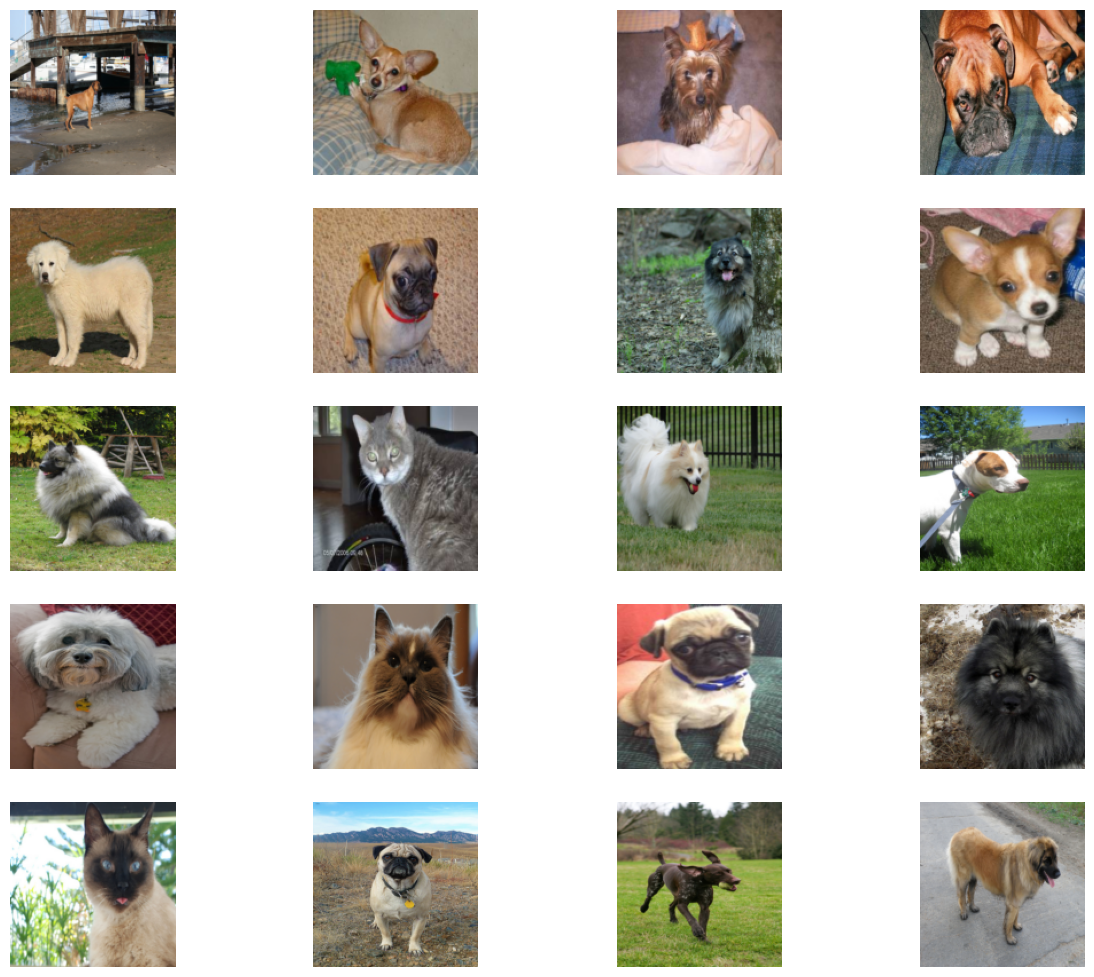

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage
from torch.utils.data import DataLoader

to_tensor = Compose([Resize((144, 144)), ToTensor()])

dataset = OxfordIIITPet(root=".", download=True, transform=to_tensor, target_types="category")

dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

def show_images(dataloader, num_samples=20, cols=4):
    plt.figure(figsize=(15, 15))
    to_pil = ToPILImage()

    images, _ = next(iter(dataloader))

    for i in range(min(num_samples, len(images))):
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(to_pil(images[i]))
        plt.axis("off")

    plt.show()

show_images(dataloader)

In [2]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b(h w) (p1 p2 c)", p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x 

sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)       

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


In [3]:
from einops import rearrange
from torch import nn
import torch

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [4]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])